In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

2022-08-16 23:50:22.076072: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-16 23:50:33.171449: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-16 23:50:33.229685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-16 23:50:33.229727: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-16 23:50:33.232009: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-16 23:50:33.234230: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [5]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[-4:]
T = len(t_star)
data = data[:, :, :, -4::]

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]


In [6]:
#layers = [3, 2*2048, 2048, 2048, 2048, 2048, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
layers = [3, 1024, 1024, 1024, 1024, 1024, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID],
        b_B=df_params.bb[ID],
        b_C=df_params.bc[ID],
        b_D=df_params.bd[ID],
        b_E=df_params.be[ID],
        b_F=df_params.bf[ID],
        V_A=df_params.Va[ID],
        V_B=df_params.Vb[ID],
        V_C=df_params.Vc[ID],
        V_D=df_params.Vd[ID],
        V_E=df_params.Ve[ID],
        V_F=df_params.Vf[ID],
        k_AA=df_params.kaa[ID],
        k_BD=df_params.kbd[ID],
        k_CE=df_params.kce[ID],
        k_DA=df_params.kda[ID],
        k_EB=df_params.keb[ID],
        k_EE=df_params.kee[ID],
        k_FE=df_params.kfe[ID],
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                print_precision=".10f")

In [7]:
results = model.train(
        epochs = 500,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(1e-4)

results2 = model.train(
        epochs = 1500,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)




Start of epoch 0


2022-08-16 23:50:48.459687: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-16 23:51:46.855643: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 823.9661254883
total loss: 10595.2563781738, total regularisd loss (sum of batches): 931704.1281738281
obs A loss: 3.3529474437, pde A loss: 3478.3565516472
obs B loss: 6.3995492682, pde B loss: 58.3750264524
obs C loss: 3.8707374576, pde C loss: 82.0579902164
obs D loss: 4479.3517494202, pde D loss: 1164.6468437784
obs E loss: 232.0887100697, pde E loss: 521.0937537402
obs F loss: 218.7319114208, pde F loss: 346.9307486307
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 194.12s

Start of epoch 10
Training observations acc over epoch: 291.1267089844
total loss: 2731.1914138794, total regularisd loss (sum of batches): 671339.4916992188
obs A loss: 221.12494981


Start of epoch 100
Training observations acc over epoch: 157.8718109131
total loss: 2146.9565353394, total regularisd loss (sum of batches): 280232.3112792969
obs A loss: 75.5671607852, pde A loss: 286.8733785152
obs B loss: 12.1186826229, pde B loss: 259.7114129066
obs C loss: 29.5312751830, pde C loss: 15.0233585089
obs D loss: 496.0707345009, pde D loss: 237.4064111710
obs E loss: 200.0167400837, pde E loss: 210.6064418554
obs F loss: 133.9265407324, pde F loss: 190.1044096947
lambda obs A: 0.7574881315, lambda pde A: 0.6089367270
lambda obs B: 0.0617185012, lambda pde B: 0.9708907008
lambda obs C: 0.1759843230, lambda pde C: 0.0787681937
lambda obs D: 3.1499743462, lambda pde D: 0.1553037763
lambda obs E: 2.6701240540, lambda pde E: 0.4662805796
lambda obs F: 1.5888407230, lambda pde F: 1.3156906366

Time taken: 297.51s

Start of epoch 110
Training observations acc over epoch: 146.1768951416
total loss: 2002.9233684540, total regularisd loss (sum of batches): 258142.5073242188
obs


Start of epoch 200
Training observations acc over epoch: 69.3874816895
total loss: 1017.4999876022, total regularisd loss (sum of batches): 190394.6445312500
obs A loss: 12.8688120171, pde A loss: 265.9596123695
obs B loss: 13.5666452646, pde B loss: 114.9081830382
obs C loss: 4.7536795139, pde C loss: 8.6992034540
obs D loss: 289.7823145390, pde D loss: 133.8214197159
obs E loss: 73.6299747825, pde E loss: 55.5427286327
obs F loss: 21.7235529721, pde F loss: 22.2438715994
lambda obs A: 0.4041393995, lambda pde A: 0.9320218563
lambda obs B: 0.3130099773, lambda pde B: 0.9467505217
lambda obs C: 0.0878234059, lambda pde C: 0.0549315289
lambda obs D: 5.3221573830, lambda pde D: 0.2605245709
lambda obs E: 2.5171372890, lambda pde E: 0.3439005911
lambda obs F: 0.6173375845, lambda pde F: 0.2002655864

Time taken: 296.24s

Start of epoch 210
Training observations acc over epoch: 64.1697692871
total loss: 955.5909271240, total regularisd loss (sum of batches): 170597.7733154297
obs A loss: 


Start of epoch 300
Training observations acc over epoch: 51.7093505859
total loss: 765.3051586151, total regularisd loss (sum of batches): 158279.1900634766
obs A loss: 2.3912889361, pde A loss: 224.5177195072
obs B loss: 13.9966045469, pde B loss: 61.5897848606
obs C loss: 5.4459206276, pde C loss: 14.6850098297
obs D loss: 226.8466691971, pde D loss: 91.7175161541
obs E loss: 38.1428478956, pde E loss: 52.4672296345
obs F loss: 23.4328258634, pde F loss: 10.0717500001
lambda obs A: 0.0116404165, lambda pde A: 0.8348740935
lambda obs B: 0.5407093167, lambda pde B: 0.3571620286
lambda obs C: 0.1292874515, lambda pde C: 0.1225223690
lambda obs D: 6.2997636795, lambda pde D: 0.3513759375
lambda obs E: 1.7805205584, lambda pde E: 0.4058266282
lambda obs F: 1.0736943483, lambda pde F: 0.0926232561

Time taken: 295.32s

Start of epoch 310
Training observations acc over epoch: 59.4112625122
total loss: 1213.5852293968, total regularisd loss (sum of batches): 191483.3195800781
obs A loss: 2.


Start of epoch 400
Training observations acc over epoch: 53.8402824402
total loss: 1067.3895373344, total regularisd loss (sum of batches): 179916.7401123047
obs A loss: 3.1058433917, pde A loss: 375.8918910027
obs B loss: 14.2717071474, pde B loss: 91.1921462417
obs C loss: 7.2274977118, pde C loss: 19.3855305836
obs D loss: 236.0154665709, pde D loss: 186.0536000133
obs E loss: 37.5667640865, pde E loss: 60.2370504737
obs F loss: 24.8544011563, pde F loss: 11.5876371339
lambda obs A: 0.0109643610, lambda pde A: 0.7794451118
lambda obs B: 0.4505817294, lambda pde B: 0.2776178122
lambda obs C: 0.1373291910, lambda pde C: 0.1535170227
lambda obs D: 6.5708971024, lambda pde D: 0.2892341018
lambda obs E: 1.9202824831, lambda pde E: 0.3850434124
lambda obs F: 0.9599716663, lambda pde F: 0.0651164874

Time taken: 296.23s

Start of epoch 410
Training observations acc over epoch: 55.5830345154
total loss: 976.2923526764, total regularisd loss (sum of batches): 178459.6660156250
obs A loss: 2


Start of epoch 0
Training observations acc over epoch: 47.0227317810
total loss: 645.4269213676, total regularisd loss (sum of batches): 130435.7679443359
obs A loss: 2.1108378172, pde A loss: 133.3626314402
obs B loss: 14.7615875453, pde B loss: 62.9711475968
obs C loss: 10.0624037683, pde C loss: 29.1907811463
obs D loss: 182.4065256119, pde D loss: 51.0980936289
obs E loss: 51.4514073431, pde E loss: 76.5837378502
obs F loss: 21.3436001837, pde F loss: 10.0841728821
lambda obs A: 0.0097282231, lambda pde A: 0.7669962049
lambda obs B: 0.4090490043, lambda pde B: 0.4047476053
lambda obs C: 0.1892537177, lambda pde C: 0.1430832297
lambda obs D: 6.4168238640, lambda pde D: 0.2959155738
lambda obs E: 1.9758185148, lambda pde E: 0.4816550016
lambda obs F: 0.8255797029, lambda pde F: 0.0813494176

Time taken: 29.75s

Start of epoch 10
Training observations acc over epoch: 27.2856826782
total loss: 432.1924004555, total regularisd loss (sum of batches): 52950.8004150391
obs A loss: 2.15946


Start of epoch 100
Training observations acc over epoch: 12.7669391632
total loss: 183.9387898445, total regularisd loss (sum of batches): 21186.0220642090
obs A loss: 2.5276452489, pde A loss: 48.3086504042
obs B loss: 11.1109564006, pde B loss: 12.2083964720
obs C loss: 1.9181771427, pde C loss: 6.4807125479
obs D loss: 40.5036074370, pde D loss: 21.5476417691
obs E loss: 14.4098105505, pde E loss: 15.5617660731
obs F loss: 6.1314225718, pde F loss: 3.2300048713
lambda obs A: 0.0744908601, lambda pde A: 0.6201056242
lambda obs B: 2.4833796024, lambda pde B: 0.3000748456
lambda obs C: 0.4101620018, lambda pde C: 0.3307583928
lambda obs D: 2.7179536819, lambda pde D: 0.4600504339
lambda obs E: 3.1482772827, lambda pde E: 0.3475152850
lambda obs F: 0.9593785405, lambda pde F: 0.1478538066

Time taken: 297.87s

Start of epoch 110
Training observations acc over epoch: 12.3088121414
total loss: 174.7206269503, total regularisd loss (sum of batches): 20789.0966339111
obs A loss: 2.59930395


Start of epoch 200
Training observations acc over epoch: 9.1762800217
total loss: 134.8540405035, total regularisd loss (sum of batches): 16517.5033111572
obs A loss: 3.0373682100, pde A loss: 36.2068474591
obs B loss: 9.1767729297, pde B loss: 8.5392996967
obs C loss: 0.8716370650, pde C loss: 4.2391825877
obs D loss: 29.2620892376, pde D loss: 16.3705567122
obs E loss: 9.6309151575, pde E loss: 11.5650776774
obs F loss: 3.0788969342, pde F loss: 2.8753964845
lambda obs A: 0.1840077788, lambda pde A: 0.7399588227
lambda obs B: 3.4405024052, lambda pde B: 0.2165255696
lambda obs C: 0.4419584572, lambda pde C: 0.1713468432
lambda obs D: 3.1276407242, lambda pde D: 0.4526644647
lambda obs E: 2.2573332787, lambda pde E: 0.2799736261
lambda obs F: 0.5792382360, lambda pde F: 0.1088499278

Time taken: 298.77s

Start of epoch 210
Training observations acc over epoch: 9.0056724548
total loss: 131.9092615843, total regularisd loss (sum of batches): 16277.4085998535
obs A loss: 3.0783305652, p


Start of epoch 310
Training observations acc over epoch: 7.7987957001
total loss: 115.6299623251, total regularisd loss (sum of batches): 14763.4306793213
obs A loss: 3.2183479033, pde A loss: 31.3254346251
obs B loss: 7.5036509410, pde B loss: 6.6371974982
obs C loss: 0.7189111277, pde C loss: 3.9383317120
obs D loss: 25.6366340816, pde D loss: 15.3729073256
obs E loss: 7.8479264192, pde E loss: 9.9555999860
obs F loss: 1.8673132062, pde F loss: 1.6077074287
lambda obs A: 0.2633697391, lambda pde A: 0.8024086356
lambda obs B: 3.6351585388, lambda pde B: 0.2257722914
lambda obs C: 0.4439927638, lambda pde C: 0.1515335888
lambda obs D: 3.3583884239, lambda pde D: 0.4295564890
lambda obs E: 1.9855710268, lambda pde E: 0.2698737681
lambda obs F: 0.3526530564, lambda pde F: 0.0817217827

Time taken: 298.44s

Start of epoch 320
Training observations acc over epoch: 7.6186761856
total loss: 115.7132580280, total regularisd loss (sum of batches): 14536.1257781982
obs A loss: 3.2222388238, pd


Start of epoch 420
Training observations acc over epoch: 6.5093050003
total loss: 100.4736918211, total regularisd loss (sum of batches): 13289.7877883911
obs A loss: 3.0650389455, pde A loss: 28.2976644337
obs B loss: 4.8882878050, pde B loss: 5.3035503104
obs C loss: 0.6460037348, pde C loss: 3.7151272483
obs D loss: 22.2350857854, pde D loss: 14.2635175064
obs E loss: 6.8825406097, pde E loss: 8.6810488477
obs F loss: 1.3388711531, pde F loss: 1.1569565525
lambda obs A: 0.3221973479, lambda pde A: 0.9028012156
lambda obs B: 2.8178017139, lambda pde B: 0.2284534127
lambda obs C: 0.5214093328, lambda pde C: 0.1576229036
lambda obs D: 3.7815678120, lambda pde D: 0.5268371701
lambda obs E: 2.0336875916, lambda pde E: 0.3340829909
lambda obs F: 0.2765549421, lambda pde F: 0.0969831347

Time taken: 298.35s

Start of epoch 430
Training observations acc over epoch: 6.2910470963
total loss: 96.8708675504, total regularisd loss (sum of batches): 13051.1395568848
obs A loss: 2.9708580095, pde


Start of epoch 530
Training observations acc over epoch: 5.6337099075
total loss: 87.3711054325, total regularisd loss (sum of batches): 12720.1935501099
obs A loss: 2.6344003528, pde A loss: 25.5610556155
obs B loss: 3.0549406260, pde B loss: 4.7980427928
obs C loss: 0.6008650232, pde C loss: 3.9308192879
obs D loss: 20.1944653690, pde D loss: 11.0006617978
obs E loss: 6.1877176203, pde E loss: 7.2755991444
obs F loss: 1.1298748311, pde F loss: 1.0026635611
lambda obs A: 0.3472445905, lambda pde A: 1.0439263582
lambda obs B: 1.7278497219, lambda pde B: 0.3494323492
lambda obs C: 0.5903325081, lambda pde C: 0.1655380130
lambda obs D: 4.3028669357, lambda pde D: 0.4861191809
lambda obs E: 2.2802977562, lambda pde E: 0.3068391681
lambda obs F: 0.2912496328, lambda pde F: 0.1083036587

Time taken: 297.92s

Start of epoch 540
Training observations acc over epoch: 5.5666441917
total loss: 85.3749722242, total regularisd loss (sum of batches): 12587.1899185181
obs A loss: 2.6183719318, pde 


Start of epoch 640
Training observations acc over epoch: 4.8384499550
total loss: 74.6275488734, total regularisd loss (sum of batches): 11249.0491943359
obs A loss: 2.5311098564, pde A loss: 22.7544258833
obs B loss: 2.3971920889, pde B loss: 4.3533428609
obs C loss: 0.5664444037, pde C loss: 3.5018993281
obs D loss: 17.1414706036, pde D loss: 8.0526998937
obs E loss: 5.4392205626, pde E loss: 5.9806134254
obs F loss: 0.9552656687, pde F loss: 0.9538638834
lambda obs A: 0.3696851730, lambda pde A: 1.1062848568
lambda obs B: 1.3569273949, lambda pde B: 0.3903836608
lambda obs C: 0.6277408004, lambda pde C: 0.1699026972
lambda obs D: 4.5078601837, lambda pde D: 0.4729749262
lambda obs E: 2.2868454456, lambda pde E: 0.3128850162
lambda obs F: 0.2827127874, lambda pde F: 0.1157983765

Time taken: 296.59s

Start of epoch 650
Training observations acc over epoch: 5.2945690155
total loss: 84.2410637140, total regularisd loss (sum of batches): 12661.2242355347
obs A loss: 2.5210552849, pde A


Start of epoch 750
Training observations acc over epoch: 4.3297681808
total loss: 66.0758503079, total regularisd loss (sum of batches): 9952.0623931885
obs A loss: 2.4647202808, pde A loss: 20.0641853362
obs B loss: 2.0364247169, pde B loss: 4.0430194922
obs C loss: 0.5338717506, pde C loss: 3.1581772864
obs D loss: 15.1432245076, pde D loss: 6.7521260157
obs E loss: 4.9334144238, pde E loss: 5.1673744284
obs F loss: 0.8669540188, pde F loss: 0.9123583925
lambda obs A: 0.4058366120, lambda pde A: 1.1247277260
lambda obs B: 1.1922881603, lambda pde B: 0.4384401739
lambda obs C: 0.6790352464, lambda pde C: 0.1776658297
lambda obs D: 4.4967494011, lambda pde D: 0.4792420268
lambda obs E: 2.2698402405, lambda pde E: 0.3097228706
lambda obs F: 0.3028669655, lambda pde F: 0.1235840395

Time taken: 296.38s

Start of epoch 760
Training observations acc over epoch: 4.8991146088
total loss: 79.8216162920, total regularisd loss (sum of batches): 12016.8061065674
obs A loss: 2.4708654415, pde A 


Start of epoch 860
Training observations acc over epoch: 3.9729139805
total loss: 63.2254217267, total regularisd loss (sum of batches): 9301.6878356934
obs A loss: 2.4111938570, pde A loss: 19.9605629593
obs B loss: 1.8163187131, pde B loss: 3.9861707985
obs C loss: 0.5042416528, pde C loss: 3.1805904545
obs D loss: 13.6953074411, pde D loss: 6.4096979685
obs E loss: 4.5966800265, pde E loss: 4.9712695479
obs F loss: 0.8137386735, pde F loss: 0.8796492135
lambda obs A: 0.4269573092, lambda pde A: 1.0982944965
lambda obs B: 1.0921818018, lambda pde B: 0.4540999532
lambda obs C: 0.7036601305, lambda pde C: 0.1778704822
lambda obs D: 4.6038966179, lambda pde D: 0.4757798016
lambda obs E: 2.1916716099, lambda pde E: 0.3104246259
lambda obs F: 0.3373382986, lambda pde F: 0.1278250813

Time taken: 296.57s

Start of epoch 870
Training observations acc over epoch: 3.9399688244
total loss: 61.5498313308, total regularisd loss (sum of batches): 9212.1678848267
obs A loss: 2.3777894415, pde A l


Start of epoch 970
Training observations acc over epoch: 3.8567736149
total loss: 63.6922822595, total regularisd loss (sum of batches): 9288.6211242676
obs A loss: 2.3429685477, pde A loss: 20.9504347891
obs B loss: 1.6719308197, pde B loss: 3.8612900935
obs C loss: 0.4850896178, pde C loss: 3.3410452381
obs D loss: 13.4017393962, pde D loss: 6.6354790814
obs E loss: 4.4514813516, pde E loss: 4.8777318485
obs F loss: 0.7874292871, pde F loss: 0.8856623750
lambda obs A: 0.4428815544, lambda pde A: 1.1038966179
lambda obs B: 1.0375502110, lambda pde B: 0.4590522051
lambda obs C: 0.7101119757, lambda pde C: 0.1693438143
lambda obs D: 4.6539473534, lambda pde D: 0.4779935479
lambda obs E: 2.1429939270, lambda pde E: 0.3198234439
lambda obs F: 0.3540263176, lambda pde F: 0.1283800453

Time taken: 296.55s

Start of epoch 980
Training observations acc over epoch: 3.9106462002
total loss: 65.4516170025, total regularisd loss (sum of batches): 9577.8036499023
obs A loss: 2.3203452956, pde A l


Start of epoch 1080
Training observations acc over epoch: 3.3533473015
total loss: 53.3547789454, total regularisd loss (sum of batches): 7768.6463317871
obs A loss: 2.2605766486, pde A loss: 16.5940573215
obs B loss: 1.5666430667, pde B loss: 3.5709890537
obs C loss: 0.4570561382, pde C loss: 2.6489804666
obs D loss: 11.1277487166, pde D loss: 5.2632298917
obs E loss: 3.9733456597, pde E loss: 4.3787998296
obs F loss: 0.7347118920, pde F loss: 0.7786405156
lambda obs A: 0.4582357109, lambda pde A: 1.1342061758
lambda obs B: 1.0218316317, lambda pde B: 0.4502701759
lambda obs C: 0.6691438556, lambda pde C: 0.1785207689
lambda obs D: 4.6391286850, lambda pde D: 0.5146829486
lambda obs E: 2.1099135876, lambda pde E: 0.3131244481
lambda obs F: 0.3745148778, lambda pde F: 0.1364268661

Time taken: 296.49s

Start of epoch 1090
Training observations acc over epoch: 3.8533606529
total loss: 64.1280364990, total regularisd loss (sum of batches): 9494.4852523804
obs A loss: 2.2483135313, pde A


Start of epoch 1190
Training observations acc over epoch: 3.4206659794
total loss: 55.3885500133, total regularisd loss (sum of batches): 8110.5183525085
obs A loss: 2.1390400380, pde A loss: 17.8768087029
obs B loss: 1.4788304120, pde B loss: 3.4951349944
obs C loss: 0.4366605098, pde C loss: 2.8304189052
obs D loss: 11.8663316667, pde D loss: 5.4818483591
obs E loss: 3.8824088909, pde E loss: 4.4132704772
obs F loss: 0.7207249026, pde F loss: 0.7670723186
lambda obs A: 0.4756324589, lambda pde A: 1.1128404140
lambda obs B: 1.0312602520, lambda pde B: 0.4645734727
lambda obs C: 0.6824895144, lambda pde C: 0.1740439981
lambda obs D: 4.6088066101, lambda pde D: 0.4952998757
lambda obs E: 2.0903828144, lambda pde E: 0.3284121752
lambda obs F: 0.3990736604, lambda pde F: 0.1371851414

Time taken: 296.21s

Start of epoch 1200
Training observations acc over epoch: 3.3946318626
total loss: 53.6202284694, total regularisd loss (sum of batches): 7951.4588813782
obs A loss: 2.1755075026, pde A


Start of epoch 1300
Training observations acc over epoch: 2.9379415512
total loss: 43.8941186666, total regularisd loss (sum of batches): 6624.3912734985
obs A loss: 2.0824428760, pde A loss: 12.9880903736
obs B loss: 1.4023322454, pde B loss: 3.0722263213
obs C loss: 0.4269591202, pde C loss: 2.0101009309
obs D loss: 9.4847976752, pde D loss: 4.2927023098
obs E loss: 3.5437105037, pde E loss: 3.2394318189
obs F loss: 0.6874062219, pde F loss: 0.6639183299
lambda obs A: 0.4338682890, lambda pde A: 1.1811157465
lambda obs B: 0.9315202832, lambda pde B: 0.4790671468
lambda obs C: 0.6145732403, lambda pde C: 0.1940167993
lambda obs D: 4.7060518265, lambda pde D: 0.5491209626
lambda obs E: 1.9342428446, lambda pde E: 0.4258413911
lambda obs F: 0.4133114815, lambda pde F: 0.1372698694

Time taken: 296.17s

Start of epoch 1310
Training observations acc over epoch: 3.1961333752
total loss: 50.9881408513, total regularisd loss (sum of batches): 7514.9622459412
obs A loss: 2.0700278394, pde A 


Start of epoch 1410
Training observations acc over epoch: 2.8527300358
total loss: 45.2306595743, total regularisd loss (sum of batches): 6623.7733230591
obs A loss: 1.9563918635, pde A loss: 14.1946145967
obs B loss: 1.3456499390, pde B loss: 3.0440175831
obs C loss: 0.4014996637, pde C loss: 2.2650036793
obs D loss: 9.3948750198, pde D loss: 4.4348568767
obs E loss: 3.3828291763, pde E loss: 3.5331256725
obs F loss: 0.6351338578, pde F loss: 0.6426615547
lambda obs A: 0.4547879994, lambda pde A: 1.0413726568
lambda obs B: 0.9864904881, lambda pde B: 0.4625320733
lambda obs C: 0.6488772631, lambda pde C: 0.1676595062
lambda obs D: 4.8642101288, lambda pde D: 0.4801774323
lambda obs E: 1.9966660738, lambda pde E: 0.3387944996
lambda obs F: 0.4135806561, lambda pde F: 0.1448511332

Time taken: 296.19s

Start of epoch 1420
Training observations acc over epoch: 2.7373061180
total loss: 41.2619445026, total regularisd loss (sum of batches): 6208.9892234802
obs A loss: 1.9659416433, pde A 

In [22]:
model.optimizer.lr.assign(1e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-05>

In [23]:
results3 = model.train(
        epochs = 50,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 2.5436556339
total loss: 36.8147987127, total regularisd loss (sum of batches): 5462.2335052490
obs A loss: 1.8867750280, pde A loss: 9.8088187873
obs B loss: 1.3034919770, pde B loss: 2.7692387141
obs C loss: 0.3806964611, pde C loss: 1.7379428307
obs D loss: 7.9893273190, pde D loss: 3.6627921443
obs E loss: 3.0836698608, pde E loss: 2.9730898477
obs F loss: 0.6179711679, pde F loss: 0.6009845487
lambda obs A: 0.4647231996, lambda pde A: 1.1422715187
lambda obs B: 1.0212763548, lambda pde B: 0.4553197920
lambda obs C: 0.6207374334, lambda pde C: 0.1755845398
lambda obs D: 4.6817498207, lambda pde D: 0.5032042861
lambda obs E: 2.0387809277, lambda pde E: 0.3171726465
lambda obs F: 0.4294726551, lambda pde F: 0.1497069448

Time taken: 28.82s

Start of epoch 1
Training observations acc over epoch: 2.4571318626
total loss: 34.1543481350, total regularisd loss (sum of batches): 5092.6747131348
obs A loss: 1.8801797312, pde A loss: 8.

Training observations acc over epoch: 2.4056978226
total loss: 33.3236168027, total regularisd loss (sum of batches): 5042.7148094177
obs A loss: 1.8823009115, pde A loss: 8.0378001407
obs B loss: 1.3068561563, pde B loss: 2.6002548002
obs C loss: 0.3865187212, pde C loss: 1.6036432125
obs D loss: 7.2503670827, pde D loss: 3.3538390845
obs E loss: 3.0106648020, pde E loss: 2.7256525476
obs F loss: 0.5974806380, pde F loss: 0.5682386598
lambda obs A: 0.4045373499, lambda pde A: 0.8775422573
lambda obs B: 0.8986818790, lambda pde B: 0.5726407170
lambda obs C: 0.5973618031, lambda pde C: 0.1701826751
lambda obs D: 5.1923184395, lambda pde D: 0.5464389920
lambda obs E: 1.7845414877, lambda pde E: 0.4488697648
lambda obs F: 0.3712638617, lambda pde F: 0.1356210709

Time taken: 29.76s

Start of epoch 12
Training observations acc over epoch: 2.4073331356
total loss: 33.3896464109, total regularisd loss (sum of batches): 5052.5818023682
obs A loss: 1.8849669490, pde A loss: 8.0801392794
obs B 

Training observations acc over epoch: 2.3991000652
total loss: 33.5213027596, total regularisd loss (sum of batches): 5056.1900024414
obs A loss: 1.8856062982, pde A loss: 8.3329727948
obs B loss: 1.3124948870, pde B loss: 2.5614038091
obs C loss: 0.3864321595, pde C loss: 1.6163067082
obs D loss: 7.1986935213, pde D loss: 3.3486991301
obs E loss: 3.0111888573, pde E loss: 2.7039395720
obs F loss: 0.6001841268, pde F loss: 0.5633807350
lambda obs A: 0.3922815919, lambda pde A: 0.8271738887
lambda obs B: 0.8790006638, lambda pde B: 0.6202329993
lambda obs C: 0.6053121686, lambda pde C: 0.1741110235
lambda obs D: 5.2746057510, lambda pde D: 0.5714696646
lambda obs E: 1.7006392479, lambda pde E: 0.4685038924
lambda obs F: 0.3556603193, lambda pde F: 0.1310084462

Time taken: 29.79s

Start of epoch 23
Training observations acc over epoch: 2.3977425098
total loss: 33.6235616207, total regularisd loss (sum of batches): 5071.4622039795
obs A loss: 1.8852889687, pde A loss: 8.4305008724
obs B 

Training observations acc over epoch: 2.3868229389
total loss: 33.6101906002, total regularisd loss (sum of batches): 5034.9768981934
obs A loss: 1.8857858665, pde A loss: 8.5343132615
obs B loss: 1.3167942753, pde B loss: 2.5181133095
obs C loss: 0.3853788539, pde C loss: 1.6246041637
obs D loss: 7.1340311542, pde D loss: 3.3684178460
obs E loss: 3.0097093098, pde E loss: 2.6906000637
obs F loss: 0.5892382781, pde F loss: 0.5532041169
lambda obs A: 0.3901264369, lambda pde A: 0.8048141599
lambda obs B: 0.8827859759, lambda pde B: 0.6240282655
lambda obs C: 0.6136986017, lambda pde C: 0.1764535755
lambda obs D: 5.3082008362, lambda pde D: 0.5667624474
lambda obs E: 1.6964205503, lambda pde E: 0.4580218196
lambda obs F: 0.3504222929, lambda pde F: 0.1282648891

Time taken: 30.02s

Start of epoch 34
Training observations acc over epoch: 2.3856022358
total loss: 33.5935661793, total regularisd loss (sum of batches): 5037.9319992065
obs A loss: 1.8827273697, pde A loss: 8.5462314114
obs B 

Training observations acc over epoch: 2.3824608326
total loss: 33.6695573330, total regularisd loss (sum of batches): 5025.7335968018
obs A loss: 1.8784866370, pde A loss: 8.6618667990
obs B loss: 1.3173837746, pde B loss: 2.5079829916
obs C loss: 0.3836350818, pde C loss: 1.6289631641
obs D loss: 7.1127480939, pde D loss: 3.3710024972
obs E loss: 3.0138432682, pde E loss: 2.6543125268
obs F loss: 0.5886682742, pde F loss: 0.5506642051
lambda obs A: 0.3919575214, lambda pde A: 0.8114434481
lambda obs B: 0.8950652480, lambda pde B: 0.6081771851
lambda obs C: 0.6257544160, lambda pde C: 0.1742494404
lambda obs D: 5.2888150215, lambda pde D: 0.5602114201
lambda obs E: 1.6942663193, lambda pde E: 0.4728916287
lambda obs F: 0.3491075635, lambda pde F: 0.1280607432

Time taken: 29.90s

Start of epoch 45
Training observations acc over epoch: 2.3846235275
total loss: 33.7905274332, total regularisd loss (sum of batches): 5042.4235954285
obs A loss: 1.8802455869, pde A loss: 8.7743853480
obs B 

In [ ]:
results4 = model.train(
        epochs = 300,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 2.3796355724
total loss: 33.6829850376, total regularisd loss (sum of batches): 5013.2031822205
obs A loss: 1.8797979355, pde A loss: 8.7091660351
obs B loss: 1.3180687772, pde B loss: 2.5011797659
obs C loss: 0.3818163811, pde C loss: 1.6369265011
obs D loss: 7.1004767939, pde D loss: 3.3506693225
obs E loss: 3.0102725718, pde E loss: 2.6582391262
obs F loss: 0.5873778441, pde F loss: 0.5489937696
lambda obs A: 0.3920817673, lambda pde A: 0.7982764244
lambda obs B: 0.8995401263, lambda pde B: 0.6050650477
lambda obs C: 0.6304544210, lambda pde C: 0.1727803349
lambda obs D: 5.2857112885, lambda pde D: 0.5451120734
lambda obs E: 1.7094550133, lambda pde E: 0.4845734835
lambda obs F: 0.3492056429, lambda pde F: 0.1277450770

Time taken: 28.71s

Start of epoch 10
Training observations acc over epoch: 2.3754525185
total loss: 33.7258065939, total regularisd loss (sum of batches): 4991.9314079285
obs A loss: 1.8748627882, pde A loss: 8

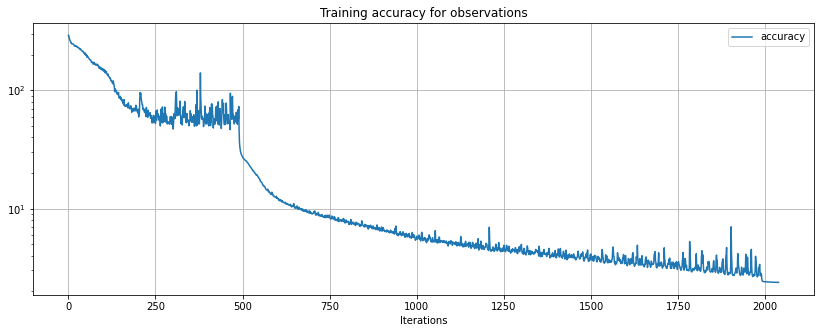

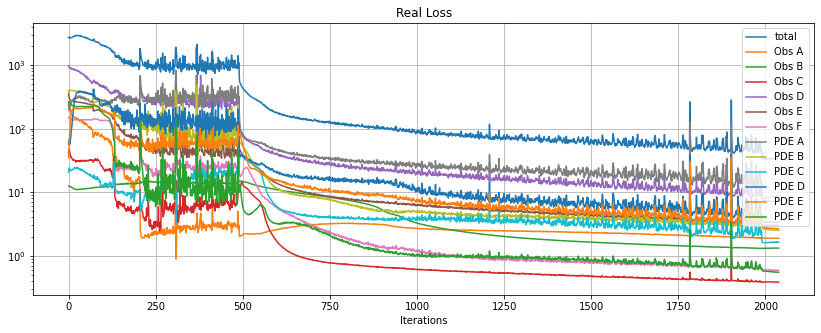

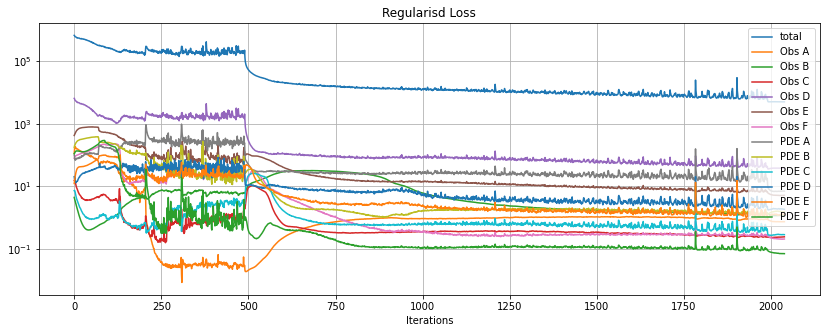

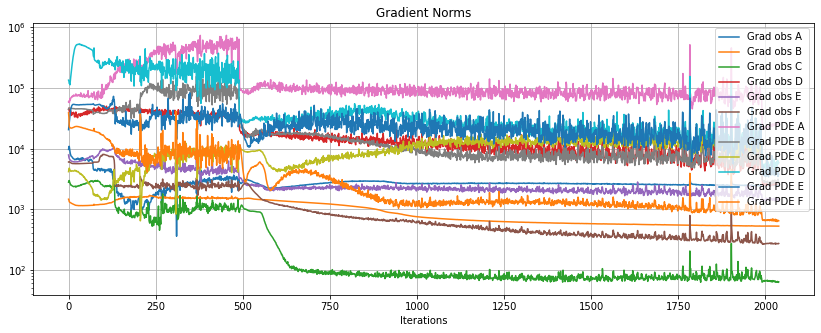

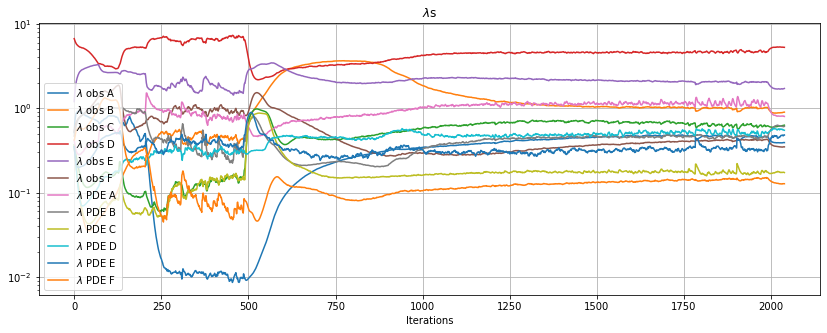

In [24]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3), 
                        node_names=node_names, start=10,  yscale='log')

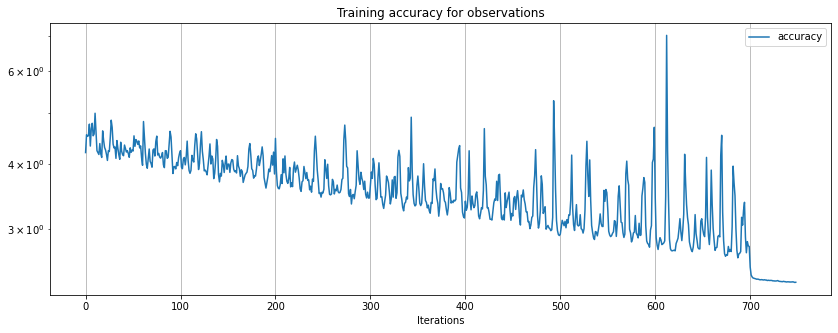

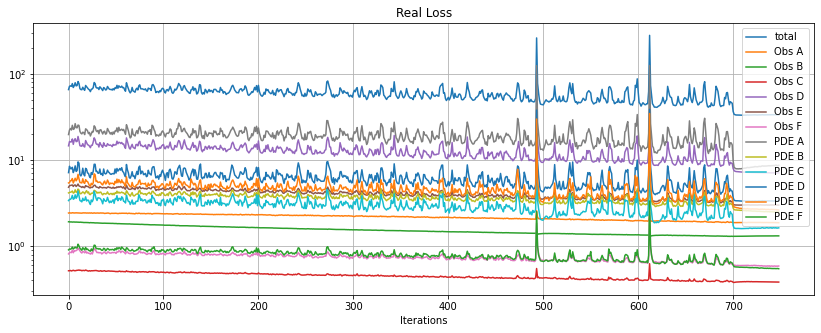

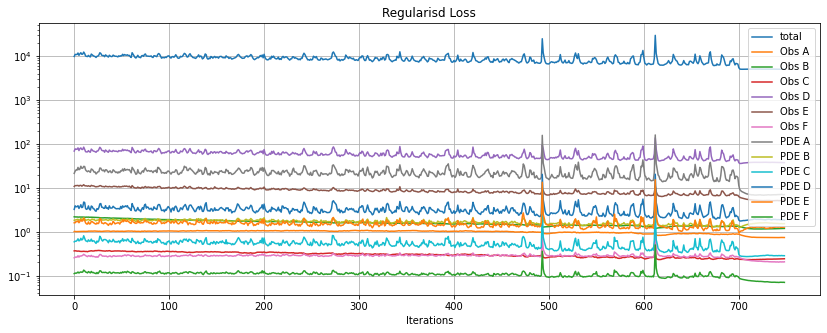

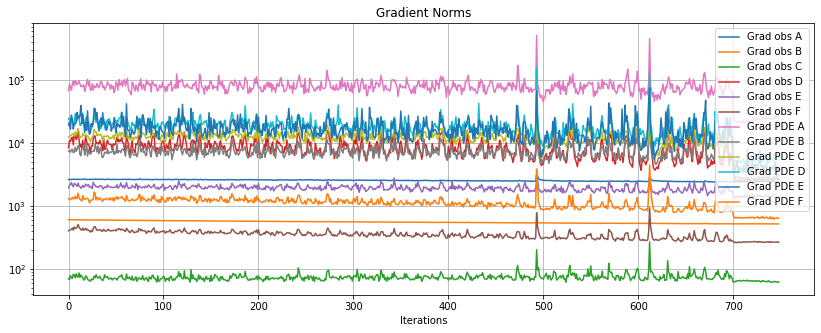

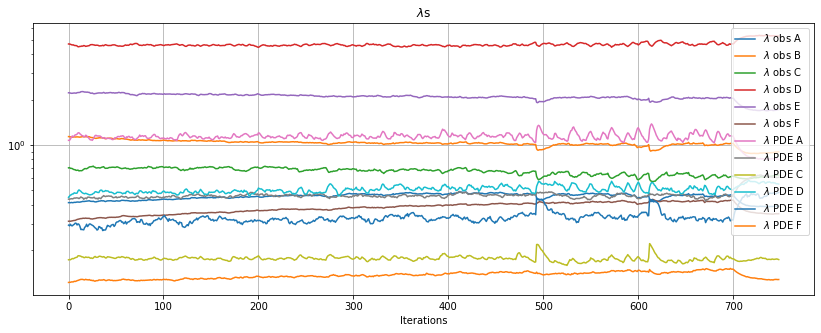

In [27]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3), 
                        node_names=node_names, start=1300,  yscale='log')

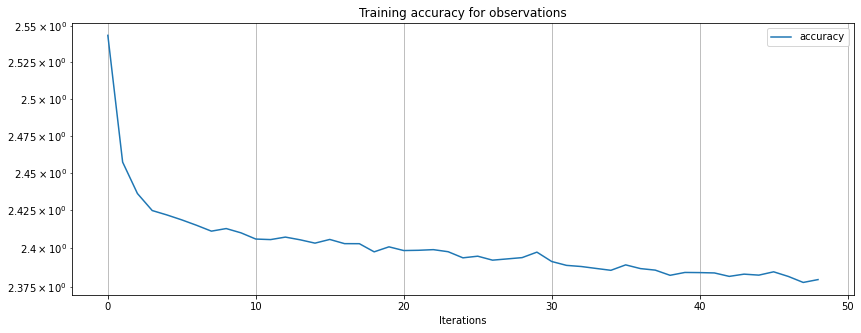

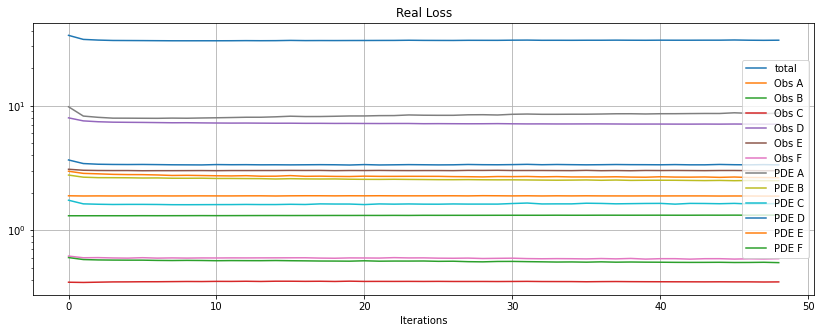

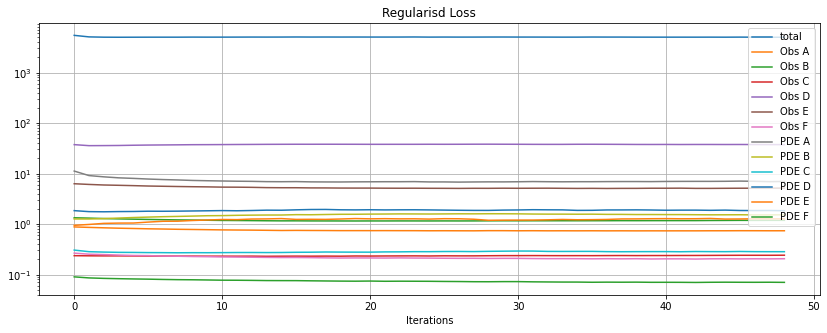

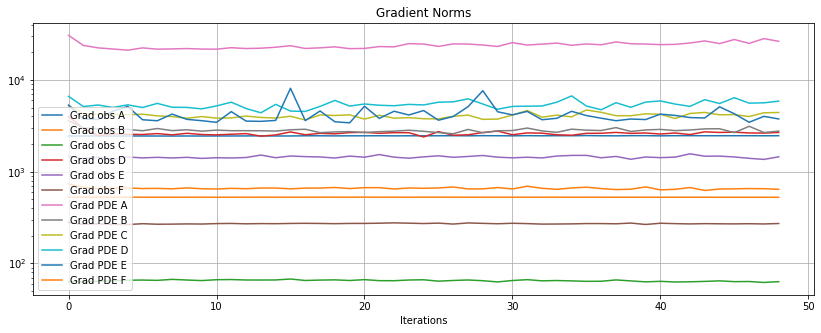

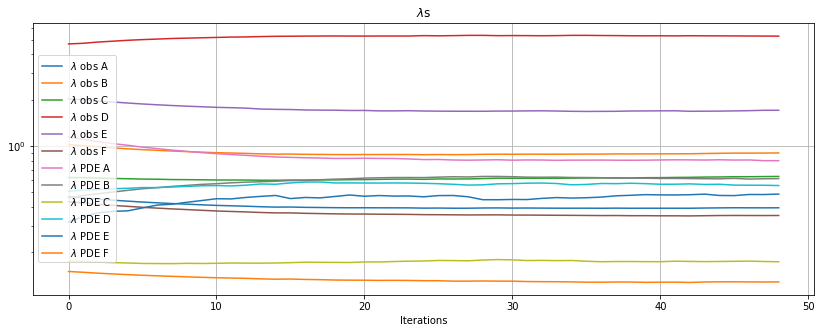

In [28]:
plot_result_multi_nodes(merge_dict_multi_nodes( results3), 
                        node_names=node_names,   yscale='log')

In [29]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

116


In [30]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

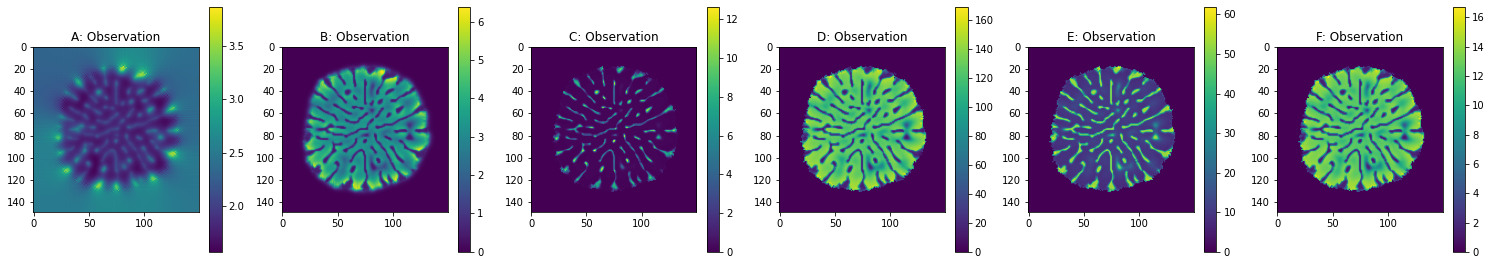

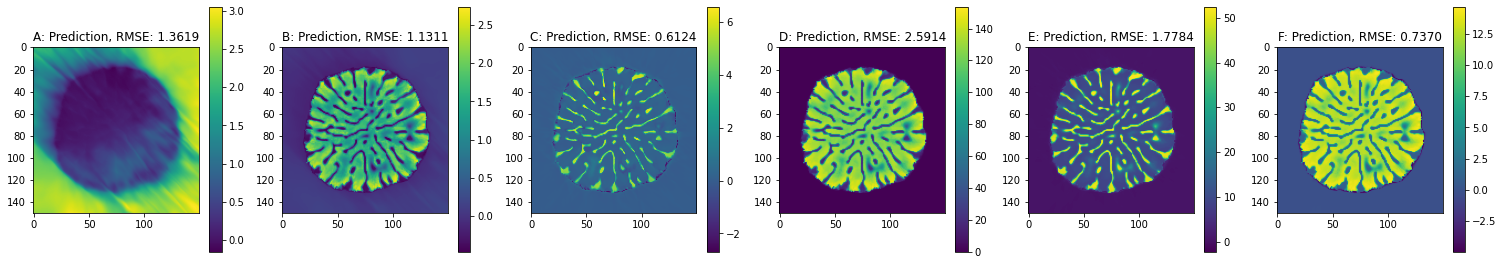

In [31]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, t_star[T_test_index]])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

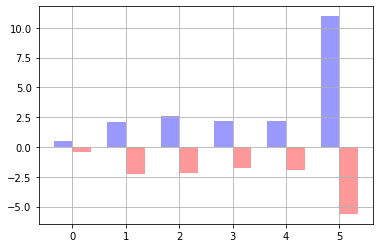

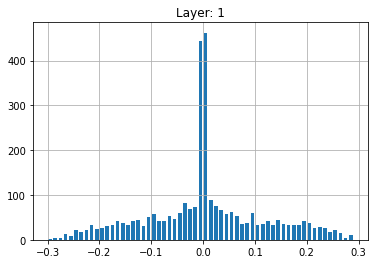

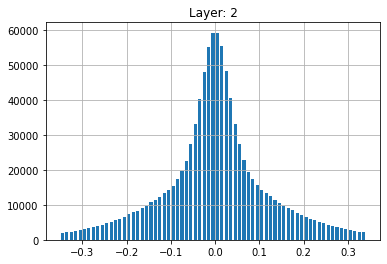

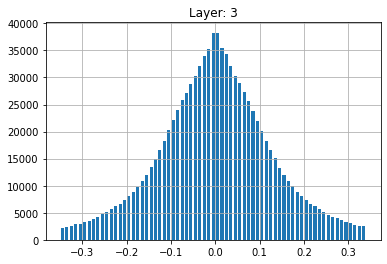

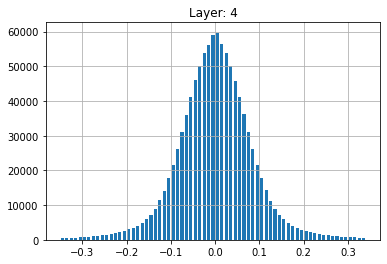

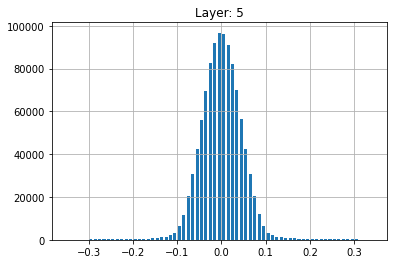

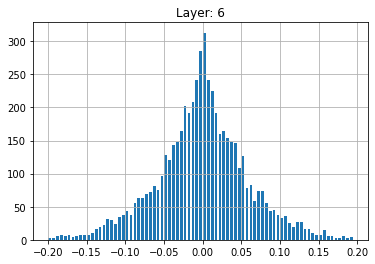

In [32]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-.3,.3,.01)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.2,0.2,.005)
    #max_ws = np.max(pinn.Ws[i].numpy())
    #min_ws = np.min(pinn.Ws[i].numpy())
    #bins = np.arange(min_ws*.8, max_ws*.8, .8*(max_ws - min_ws)/20)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [33]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T

In [34]:
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pdes = np.zeros((test_d.shape[0], len(node_names)))

for i, _ in enumerate(test_d):
    outs, pde_outs = pde_loss.loss_multi_nodes(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pdes[i] = [item.numpy() for item in pde_outs]

In [35]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pdes = np.array([ test_pdes[:, i].reshape((x_size, y_size)) for i in range(test_pdes.shape[1])]) 

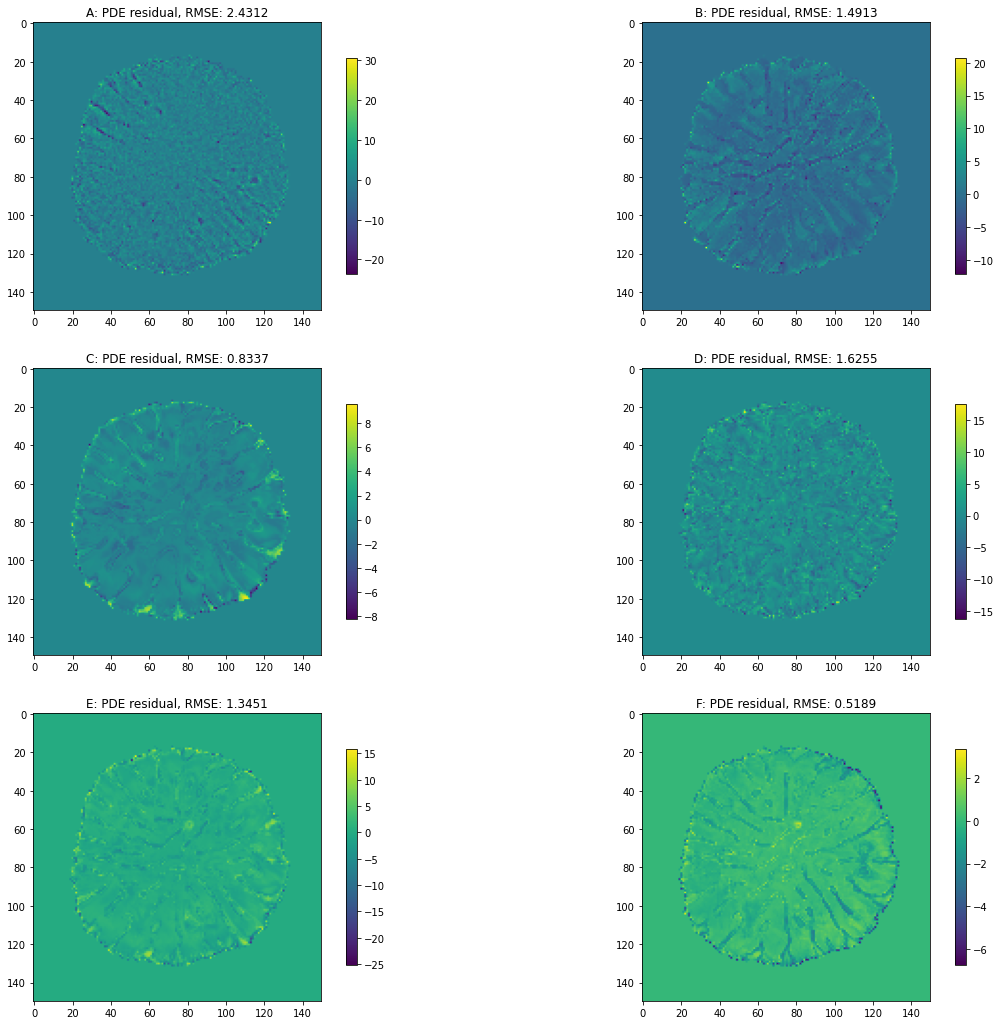

In [36]:
_ = plt.figure(figsize=(20,18))
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual, RMSE: {rmse:.4f}")
    
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

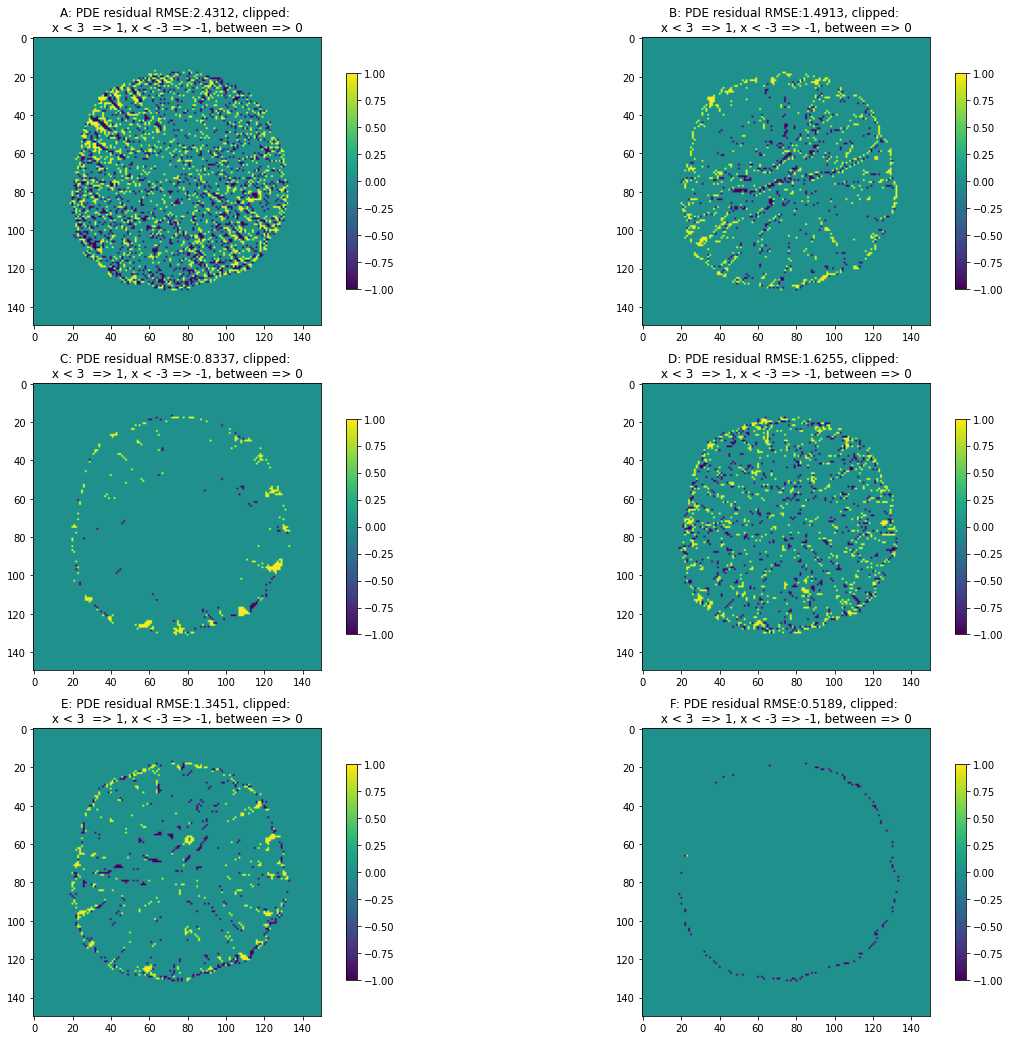

In [37]:
_ = plt.figure(figsize=(20,18))
max_L = 3
min_L = -3
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x < {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()